### Install and Import Packages

In [1]:
# Utils import 
import import_ipynb
from Utils import * 

# Imports 
import os 
import torch
import numpy as np 
from PIL import Image
from evaluate import load
from datasets import load_dataset 
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModelForCausalLM, ViTImageProcessor, TrainingArguments, Trainer

importing Jupyter notebook from Utils.ipynb


C:\Users\Sania\image-captioning\img_captioning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset creation

#### Define Data Paths 

In [2]:
DATA_PATHS["save_model_dir"] += "vit/"
DATA_PATHS["checkpoints_dir"] += "vit/"

#### Create metadata.jsonl file

The dataset is organized as directed on the huggingface documentation on creating an image dataset 
        https://huggingface.co/docs/datasets/v2.7.1/en/image_dataset
    
Captions structure :

    [{file_name: "404/404.png", "prompt": "This is a 404 page design"}]

### Define and Preprocess Datasets

In [3]:
# Define the directory containing your images
data_files = [img for img in os.listdir(DATA_PATHS["image_set_path"]) if img != '.gitkeep']

# Preprocess images to convert RGBA to RGB
for category in data_files: 
    if "metadata" not in category:
        for filename in os.listdir(os.path.join(DATA_PATHS["image_set_path"], category)):
            filepath = os.path.join(DATA_PATHS["image_set_path"], category, filename)
            if os.path.isfile(filepath):
                try:
                    img = Image.open(filepath)
                    if img.mode == 'RGBA'or img.mode == 'P':
                        img = img.convert('RGB')
                        # Save the converted image 
                        img.save(filepath)  
                except Exception as e:
                    print(f"Error processing image {filename}: {e}")

In [4]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, image_processor, processor):
        self.dataset = dataset
        self.image_processor = image_processor
        self.processor = processor
        self.max_text_length=512

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = {}
        
        image_encoding = self.image_processor(images=item["image"], return_tensors="pt")
        text_encoding = self.processor(text=item["prompts"], return_tensors="pt")
        
        # Padding
        input_ids = text_encoding["input_ids"].tolist()[0]        
        attention_mask = text_encoding["attention_mask"].tolist()[0]
        
        encoding["pixel_values"] = image_encoding.pixel_values
        encoding["input_ids"] = torch.tensor(input_ids + [0] * (self.max_text_length - len(input_ids)))
        encoding["attention_mask"] = torch.tensor(attention_mask + [0] * (self.max_text_length - len(attention_mask))) 
        encoding.update({"labels": encoding["input_ids"]})

                                                  
        # Remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding     

In [5]:
dataset = load_dataset("imagefolder", data_dir=DATA_PATHS["image_set_path"], split="train", drop_labels=False)
train_dataset, test_dataset = dataset.train_test_split(train_size=int(len(dataset) * 0.8), test_size=int(len(dataset) * 0.2)).values()

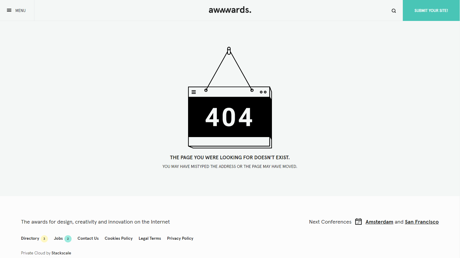

In [6]:
example = train_dataset[2]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [8]:
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning", kwargs="padding")
processor= AutoTokenizer.from_pretrained("microsoft/git-large", kwargs="padding")

In [9]:
processor.pad_token

'[PAD]'

In [10]:
train_ds = ImageCaptioningDataset(train_dataset, image_processor, processor)
test_ds = ImageCaptioningDataset(test_dataset, image_processor, processor)

In [11]:
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=50)
test_dataloader = DataLoader(test_ds, shuffle=True, batch_size=10)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([50, 3, 224, 224])
input_ids torch.Size([50, 512])
attention_mask torch.Size([50, 512])
labels torch.Size([50, 512])


### Training

In [13]:
wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [14]:
training_args = TrainingArguments(
    output_dir=DATA_PATHS["checkpoints_dir"],
    learning_rate=5e-5,
    num_train_epochs=1,
    gradient_accumulation_steps=1,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=1,
    save_strategy="steps",
    save_steps=1,
    logging_steps=1,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [15]:
model = AutoModelForCausalLM.from_pretrained("microsoft/git-large")

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Wer Score
1,11.945800,10.292853,31.262873
2,10.309000,9.914738,32.685637
3,9.939000,9.547761,42.653117
4,9.558500,9.238697,27.997290
5,9.262900,9.040634,46.203252
6,9.148500,8.827823,26.856369
7,8.894600,8.699294,31.739837
8,8.788800,8.593913,37.170732
9,8.666900,8.510213,40.189702
10,8.610700,8.448247,41.626016


TrainOutput(global_step=12, training_loss=9.34450109799703, metrics={'train_runtime': 2041.0237, 'train_samples_per_second': 0.047, 'train_steps_per_second': 0.006, 'total_flos': 109030597263360.0, 'train_loss': 9.34450109799703, 'epoch': 1.0})

#### Plot loss curves 

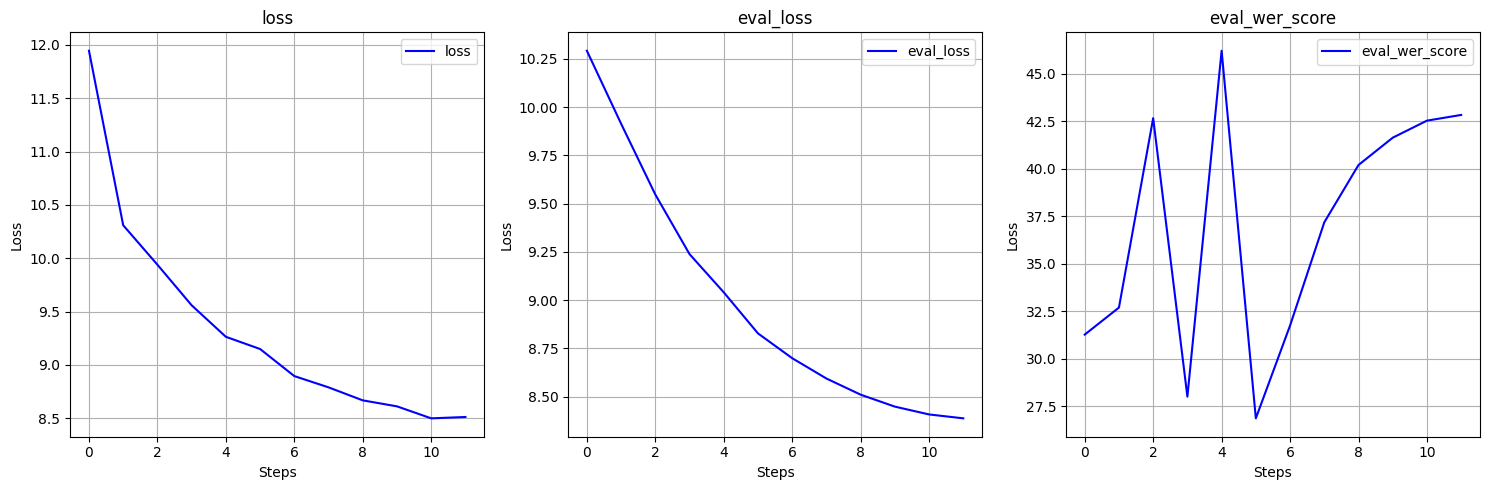

In [17]:
track_losses(trainer)

#### Save model 

In [18]:
trainer.save_model(DATA_PATHS["save_model_dir"])

### Inference

In [19]:
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning", kwargs="padding")
processor= AutoTokenizer.from_pretrained("microsoft/git-large", kwargs="padding")

model = AutoModelForCausalLM.from_pretrained("microsoft/git-large")

In [20]:
inference_dict = {}
inference_files = [img for img in os.listdir(DATA_PATHS["inference_set_dir"]) if img != '.gitkeep']

for img in inference_files:
    image = Image.open(DATA_PATHS["inference_set_dir"] + img).convert("RGB")
    
    pixel_values = image_processor(images=image, return_tensors="pt").pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=200, num_return_sequences=5, top_k=100, do_sample=True, temperature=0.8)
    inference_dict[img] = processor.batch_decode(generated_ids, skip_special_tokens=True)

complete_image_set/inference/404.png


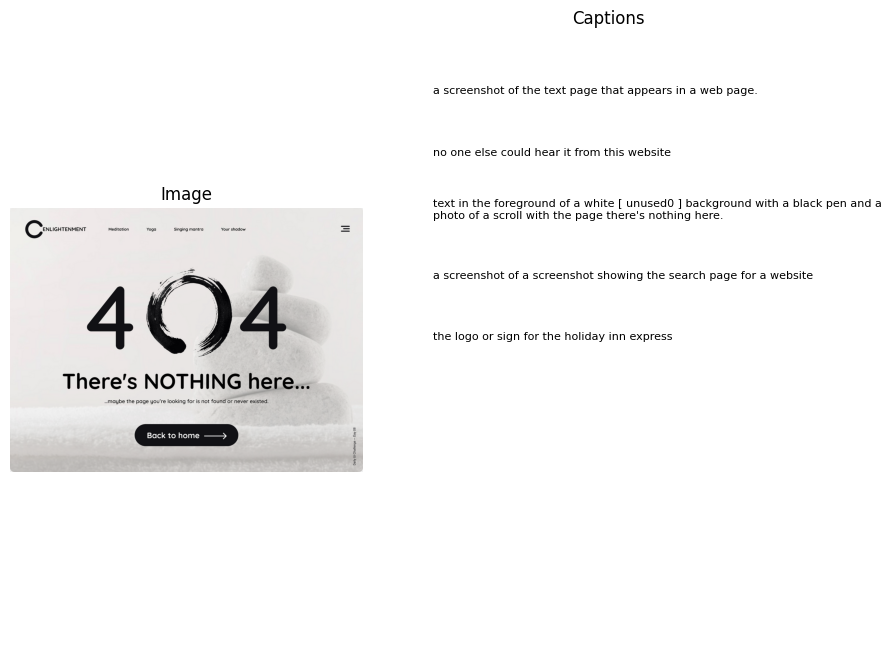

complete_image_set/inference/about_test.jpg


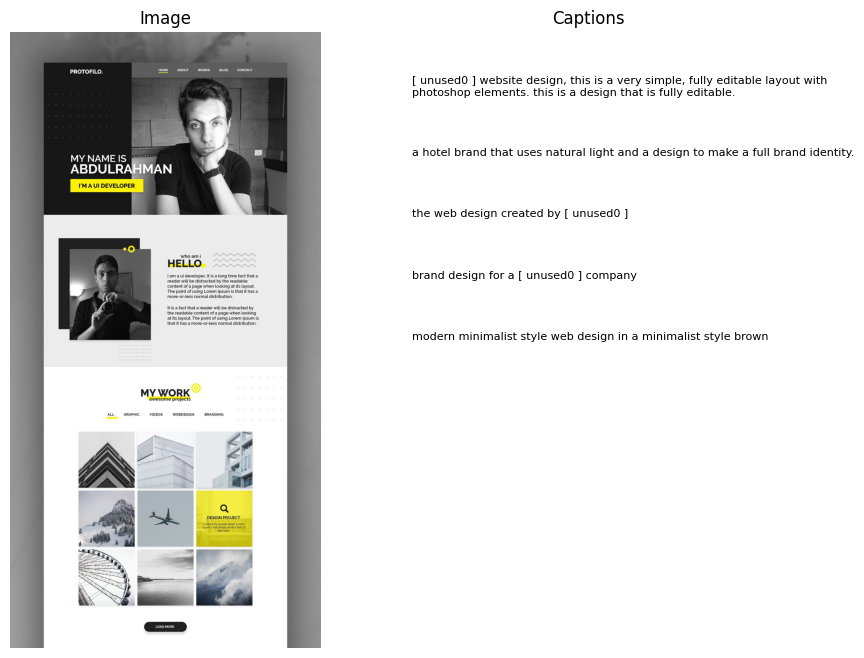

complete_image_set/inference/about_us_test.png


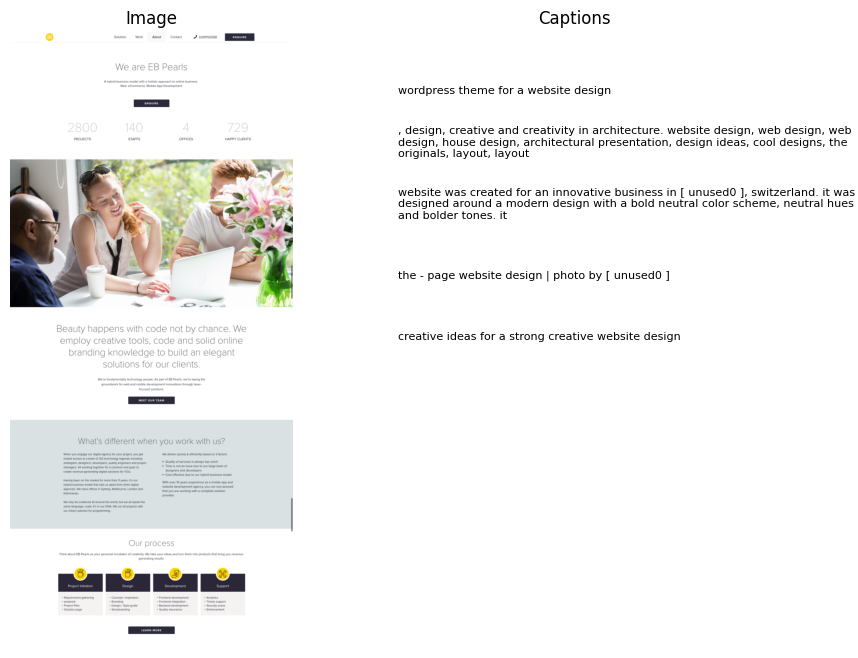

In [21]:
for image, captions in inference_dict.items(): 
    print(DATA_PATHS["inference_set_dir"] + image)
    plot_image_with_captions(DATA_PATHS["inference_set_dir"] + image, captions)